<a href="https://colab.research.google.com/github/pachterlab/GFCP_2021/blob/main/notebooks/occup_meas_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
t1 = time.time()

# Dependencies and functions


In [2]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})

In [3]:
%%capture
!pip install --upgrade git+https://github.com/meichenfang/velocyto.py.git

In [4]:
%%capture
!pip install scanpy
!pip install umap-learn

In [5]:
from vis import *

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


# Simulation

Generate simulation data.

In [6]:
!mkdir -p data

In [7]:
nCells,nGenes,T,tau,topo =  2000,100,10,[0,3,7],"aba"
name="data/simdata_aba"
meta = nCells,nGenes,T,tau,topo
simdata = simulate_occup_meas(nCells,nGenes,T,tau,topo,seed=42)
sim_export(simdata,meta,name)

## Fig 10: The RNA velocity count processing and inference workflow, applied to data generated by stochastic simulation

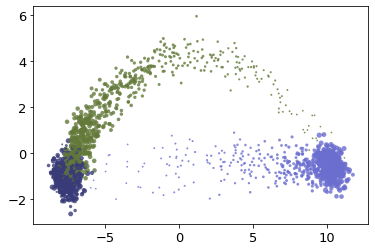

In [8]:
vlm = vcy.VelocytoLoom(loom_filepath=name+".loom")
preprocess(vlm,sim=True,meta=meta,filter=False,sz_normalize=False)
fig,ax=plt.subplots(1,1,figsize=(6,4))
plotEmbed(ax,vlm,"pcs",sim=True)

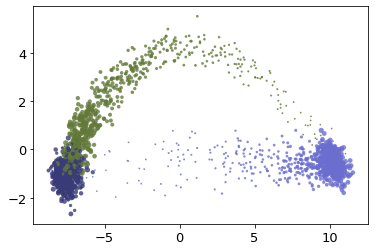

In [9]:
vlm = vcy.VelocytoLoom(loom_filepath=name+".loom")
preprocess(vlm,sim=True,meta=meta,filter=False,sz_normalize=True)
fig,ax=plt.subplots(1,1,figsize=(6,4))
plotEmbed(ax,vlm,"pcs",sim=True)

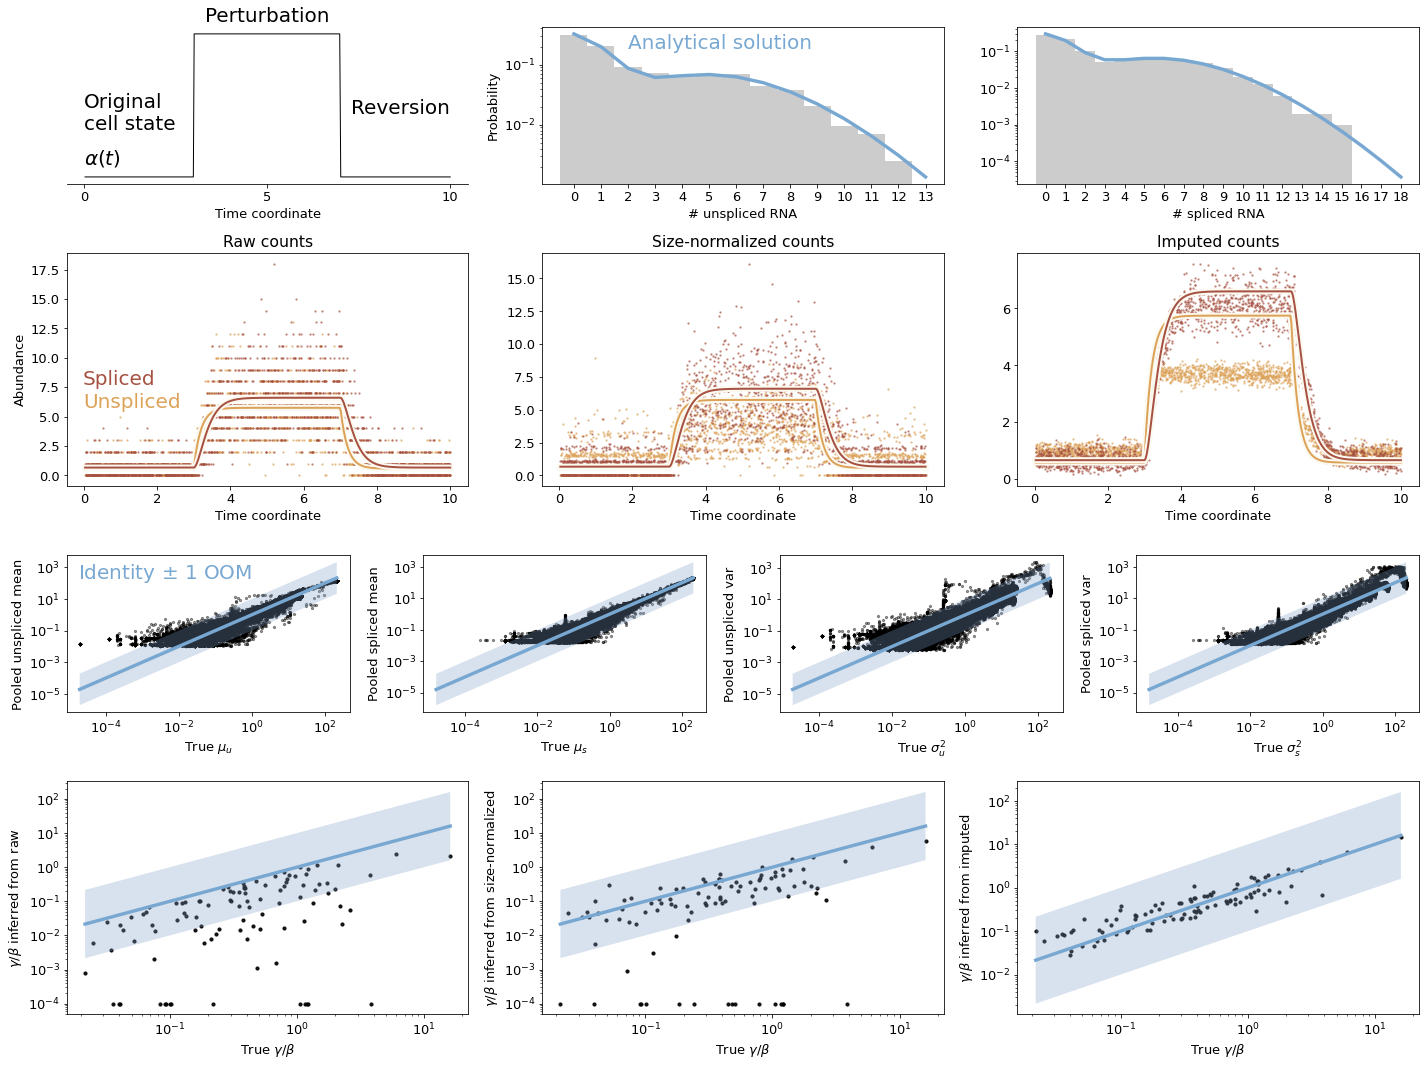

In [10]:
fig=simValidPlots(vlm,tau,meta,geneind=2)
fig.tight_layout()

In [11]:
!mkdir -p figure

In [12]:
fig.savefig('figure/fig_aba_valid_raw.png',dpi=600)

In [13]:
t2 = time.time()
print('Notebook runtime: {:.1f} seconds.'.format(t2-t1))

Notebook runtime: 129.3 seconds.
